# Analiza i selekcija podataka pomoću SOM Klasterovanja

Krive sjaja kvazara su inherentno stohastične i neregularne, što predstavlja izazov za tradicionalne metode analize vremenskih serija. Mi ćemo ovde koristiti SOM klasterovanje kako bismo izvukli podskup celog dataseta u kom se krive ponašaju relativno slično, kako bismo imali veće šanse da dobijemo smislen rezultat nakon treniranja modela (bar za kvazare koji su slični onima iz najvećeg klastera).

In [1]:
from QNPy_Latte.Clustering_with_SOM import *

import numpy as np
import pandas as pd
import os
import re
from collections import Counter
import pickle 
import matplotlib.pyplot as plt

c:\Users\spnem\miniconda3\envs\efem2_env\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


## 1. Učitavanje podataka

Koristimo funkciju `Load_Light_Curves` da učitamo sve `.csv` fajlove iz direktorijama sa krivama.

In [2]:
data_directory = 'Light_Curves'

light_curves, ids = Load_Light_Curves(data_directory, one_filter=True)

print(f"Učitano {len(light_curves)} kriva.")

Loading all curves: 100%|██████████| 100/100 [00:00<00:00, 634.75it/s]

Učitano 100 kriva.


Plotujemo prvu učitanu krivu kako bismo osigurali da su podaci dobro učitani:

In [3]:
Plot_Lc(light_curves[0], x_axis='mjd', save_fig=True)

## 2. Priprema podataka za SOM klasterovanje

SOM algoritam zahteva da svi ulazni podaci budu vektori **fiksne dužine** i često daje bolje rezultate kada su podaci **skalirani** (npr. normalizovani ili standardizovani). Naše sirove svetlosne krive ne zadovoljavaju ove uslove, pa ih moramo pripremiti.

Da bismo sve krive doveli na istu dužinu, koristimo funkciju `Pad_Light_Curves`. Ona će ili skratiti duže krive ili dodati "lažne" vrednosti (padding) kraćim krivama dok ne dostignu željenu dužinu.

In [4]:
desired_length = 100
padded_curves = Pad_Light_Curves(light_curves, desired_length)

Padding Light Curves: 100it [00:00, ?it/s]


Da bismo osigurali da SOM algoritam upoređuje oblike krivih, a ne njihove apsolutne magnitude, skaliramo vrednosti magnituda u neki standardizovani opseg. Iz koda koji sledi će se videti da je taj opseg [-2, 2]. 

In [5]:

scaled_curves, scaled_times = scale_curves(padded_curves)

min_old = np.min(np.transpose(padded_curves)[1])
max_old = np.max(np.transpose(padded_curves)[1])
avg_old = np.average(np.transpose(padded_curves)[1])
print(f"\nStari podaci: min mag: {min_old:.2f}, max mag: {max_old:.2f}, avg mag: {avg_old:.2f}")

min_new = np.min(np.transpose(scaled_curves)[1])
max_new = np.max(np.transpose(scaled_curves)[1])
avg_new = np.average(np.transpose(scaled_curves)[1])
print(f"Novi podaci : min mag: {min_new:.2f}, max mag: {max_new:.2f}, avg mag: {avg_new:.2f}")

Scaling Times: 100%|██████████| 100/100 [00:00<00:00, 237.99it/s]


Stari podaci: min mag: 18.43, max mag: 23.67, avg mag: 20.91
Novi podaci : min mag: -2.00, max mag: 2.00, avg mag: -0.04


## 2. Obuka SOM modela

Sada kada su podaci pripremljeni (fiksne dužine i skalirani), možemo da obučimo Self-Organizing Map (SOM). SOM je tip neuronske mreže koja uči da mapira visokodimenzionalne ulazne podatke (naše svetlosne krive) na niskodimenzionalnu mrežu (u našem slučaju, 1D liniju) neurona. Svaki neuron u SOM mreži uči da predstavlja "prototip" određenog oblika krive.

Koristimo funkciju `SOM_1D` za obuku jednodimenzionalnog SOM-a.

In [6]:
num_epochs_som = 10000
plot_freq_som = 1000
batch_size_som = 1

print(f"Pokretanje SOM obuke za {num_epochs_som} epoha...")

som_model, q_error, t_error, indices_to_plot = SOM_1D(
    scaled_curves,
    pca_init=False,
    save_som=False,
    train_mode='random',
    epochs=num_epochs_som,
    plot_frequency=plot_freq_som,
    batch_size=batch_size_som
)

print("SOM obuka završena.")

Pokretanje SOM obuke za 10000 epoha...


Evaluating SOM: 100%|██████████| 10000/10000 [00:00<00:00, 11385.78it/s]

SOM obuka završena.


## 3. Analiza rezultata klasterovanja

Nakon što je SOM obučen, možemo ga iskoristiti da svakoj ulaznoj svetlosnoj krivi dodelimo oznaku klastera kojem najviše pripada (tj. neuronu čiji je težinski vektor najbliži toj krivoj). Za naredni notebook ćemo pripremiti podatke krivih iz najvećeg klastera, i njih ćemo koristiti za treniranje modela. Sada tražimo najveći klaster:

In [7]:
cluster_map = Assign_Cluster_Labels(som_model, scaled_curves, ids)

largest_cluster_label = None
largest_cluster_size = 0

# Izvlačimo kolonu sa oznakama klastera
cluster_labels = cluster_map['Cluster'].tolist()

# Prebrojavamo koliko puta se svaka oznaka pojavljuje
label_counts = Counter(cluster_labels)

# Sortiramo po broju pojavljivanja (od najvećeg ka najmanjem)
sorted_counts = label_counts.most_common()

# Uzimamo oznaku i veličinu prvog (najvećeg)
largest_cluster_label = sorted_counts[0][0]
largest_cluster_size = sorted_counts[0][1]

print(f"Pronađeno je {len(label_counts)} klastera.")
print(f"Najveći klaster ima oznaku: {largest_cluster_label}")
print(f"Broj svetlosnih kriva u najvećem klasteru: {largest_cluster_size}")


Creating Dataframe: 100%|██████████| 100/100 [00:00<00:00, 16887.32it/s]

Pronađeno je 16 klastera.
Najveći klaster ima oznaku: 13
Broj svetlosnih kriva u najvećem klasteru: 11


Da bismo bolje razumeli kvalitet klasterovanja i karakteristike klastera, možemo koristiti dodatne funkcije za vizualizaciju i izračunavanje metrika.

`Gradient_Cluster_Map`: Vizualizuje SOM mapu.

`Cluster_Metrics`: Računa metrike za evaluaciju klasterovanja.

`Plot_SOM_Scaled_Average`: Plota naučene prototipove krivih sjaja.

`SOM_Clusters_Histogram`: Prikazuje histogram broja krivih po klasteru.

In [8]:
gradient_cluster_map = Gradient_Cluster_Map(som_model, scaled_curves, ids)

print("Metrike kvaliteta klasterovanja:")
silhouette_score = Cluster_Metrics(scaled_curves, cluster_map, 'Silhoutte')
dbi_score = Cluster_Metrics(scaled_curves, cluster_map, 'DBI')
ch_score = Cluster_Metrics(scaled_curves, cluster_map, 'CH')
print(f"  Silhouette Score: {silhouette_score:.3f} (Bliže 1 je bolje)")
print(f"  Davies-Bouldin Index (DBI): {dbi_score:.3f} (Bliže 0 je bolje)")
print(f"  Calinski-Harabasz Index (CH): {ch_score:.1f} (Više je generalno bolje)")


Metrike kvaliteta klasterovanja:
  Silhouette Score: 0.116 (Bliže 1 je bolje)
  Davies-Bouldin Index (DBI): 1.696 (Bliže 0 je bolje)
  Calinski-Harabasz Index (CH): 10.3 (Više je generalno bolje)


Plotujemo dobijene klastere radi vizuelne reprezentacije:

Creating Plots: 100%|██████████| 4/4 [00:11<00:00,  2.98s/it]


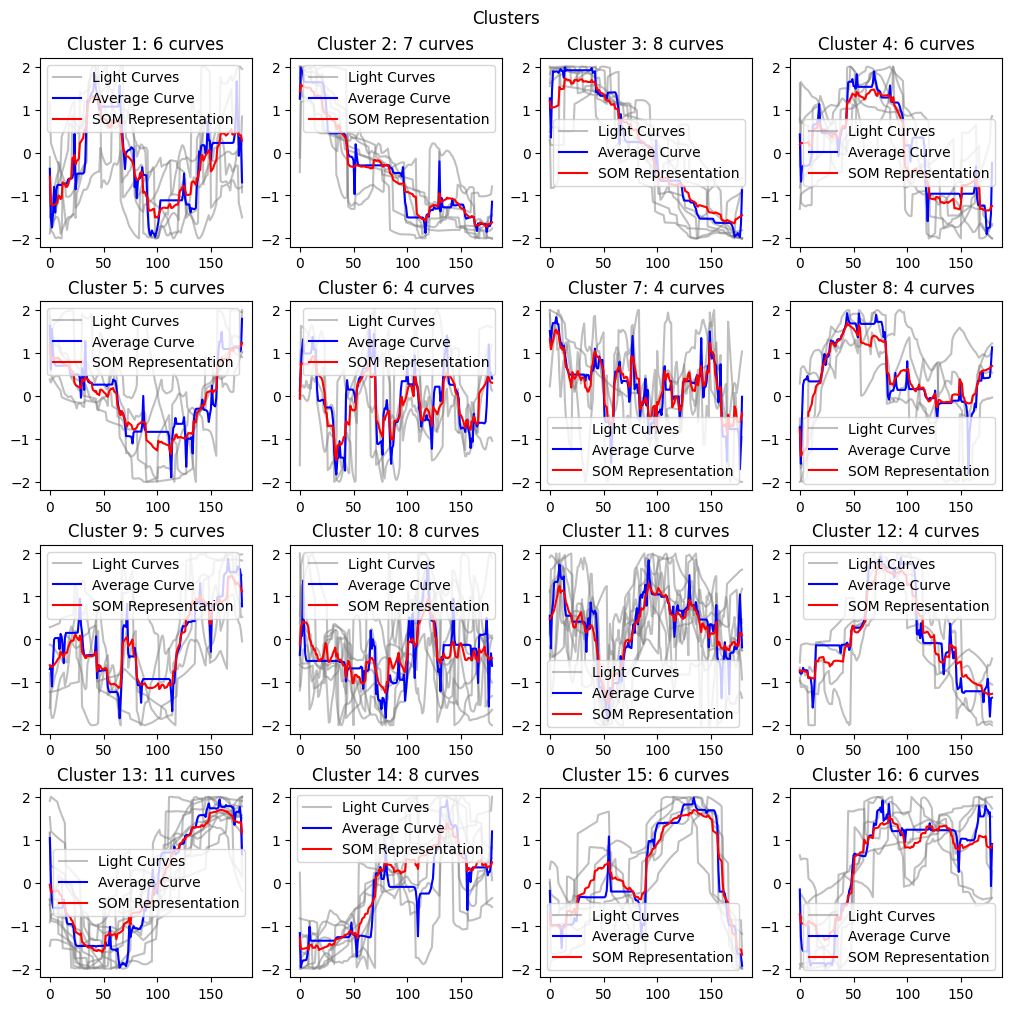

In [9]:
Plot_SOM_Scaled_Average(som_model, scaled_curves)

Plotujemo histogram broja kvazara po klasteru:

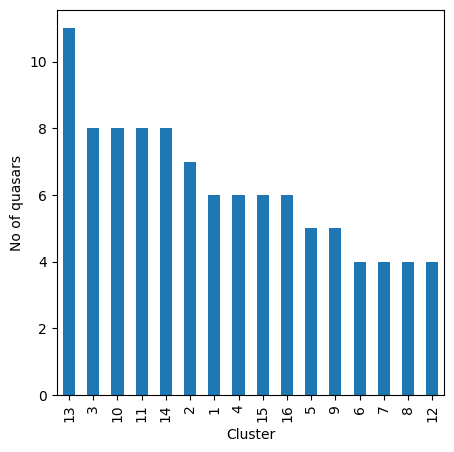

In [10]:
SOM_Clusters_Histogram(cluster_map)

## 4. Selekcija i čuvanje podataka iz najvećeg klastera

Sada kada smo identifikovali najveći klaster, filtriraćemo originalne podatke da zadržimo samo krive koje pripadaju tom klasteru i sačuvaćemo ih kao nove `.csv` fajlove za upotrebu u narednom notebooku.

In [11]:
# Inicijalizacija praznih listi za filtrirane podatke
largest_cluster_light_curves = []
largest_cluster_ids = []

# Kreiranje mape ID -> originalni indeks za brzi pristup
id_to_index = {lc_id: index for index, lc_id in enumerate(ids)}

# Filtriramo DataFrame da dobijemo samo redove (ID, Cluster) za najveći klaster
filtered_df = cluster_map[cluster_map['Cluster'] == largest_cluster_label]

# Izvlačimo listu ID-jeva iz filtriranog DataFrame-a
largest_cluster_ids_from_df = filtered_df['ID'].tolist()

# Koristimo filtrirane ID-jeve i mapu indeksa da izvučemo originalne objekte kriva
for lc_id in largest_cluster_ids_from_df:
    original_index = id_to_index.get(lc_id)
    largest_cluster_light_curves.append(light_curves[original_index])
    largest_cluster_ids.append(lc_id)

In [12]:
output_csv_dir = 'output/Largest_Cluster_CSVs'

os.makedirs(output_csv_dir, exist_ok=True)

saved_count_final = 0
for i, lc_dataframe in enumerate(largest_cluster_light_curves):
     df_to_save = lc_dataframe[['mjd', 'mag', 'magerr']]
     
     filename = f"cluster_lc_{i}.csv"
     
     full_path = os.path.join(output_csv_dir, filename)
     
     df_to_save.to_csv(full_path, index=False)
     saved_count_final += 1

print(f"\nZavršeno čuvanje. Ukupno sačuvano fajlova: {saved_count_final} u direktorijum: '{output_csv_dir}'")


Završeno čuvanje. Ukupno sačuvano fajlova: 11 u direktorijum: 'output/Largest_Cluster_CSVs'
